# Short Term Load Forecasting (Hourly)

A range of ML based experiments have been done for hourly load forcasting for given parameters (or features).

In [85]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
import time
import gc

**Colab Config**

In [86]:
# from google.colab import drive 
# drive.mount ("/content/drive/")

## Architecture of the Work 

$ \fbox{Load Datasets} -->  \fbox{Feature Engineering}  --> \fbox{Data Processing} --> \fbox{Train-Val-Test Split} --> \fbox{Model Training} --> \fbox{Prediction}$ 



## Load Dataset

In this work ISO-NE dataset has been considered. Dataset is taken from this work:
https://github.com/yalickj/load-forecasting-resnet

In [87]:
df_master = pd.read_csv('dataset/selected_data_ISONE.csv') #in laptop
# df_master = pd.read_csv('/content/drive/MyDrive/selected_data_ISONE.csv') #in colab

In [88]:
df_master.head()

,date,year,month,day,weekday,hour,demand,temperature
0,2003/3/1,2003,3,1,7,1,12863.0,23
1,2003/3/1,2003,3,1,7,2,12389.0,22
2,2003/3/1,2003,3,1,7,3,12155.0,21
3,2003/3/1,2003,3,1,7,4,12072.0,21
4,2003/3/1,2003,3,1,7,5,12160.0,22


In [89]:
print("Number of Samples:",df_master.shape[0])
print("Number of Days:" ,len(df_master.date.unique()))

Number of Samples: 103776
Number of Days: 4324


### Data Analysis

In [90]:
df_temp_2014 = df_master[df_master.year==2014]

In [91]:
df_temp_2014

,date,year,month,day,weekday,hour,demand,temperature
95016,2014/1/1,2014,1,1,4,1,13821.0,20
95017,2014/1/1,2014,1,1,4,2,13280.0,19
95018,2014/1/1,2014,1,1,4,3,12885.0,17
95019,2014/1/1,2014,1,1,4,4,12729.0,17
95020,2014/1/1,2014,1,1,4,5,12779.0,17
...,...,...,...,...,...,...,...,...
103771,2014/12/31,2014,12,31,4,20,16955.0,22
103772,2014/12/31,2014,12,31,4,21,16243.0,21
103773,2014/12/31,2014,12,31,4,22,15525.0,21
103774,2014/12/31,2014,12,31,4,23,14759.0,18


<AxesSubplot:>

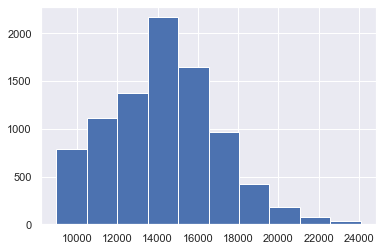

In [92]:
df_temp_2014.demand.hist() #histogram of samples

<AxesSubplot:>

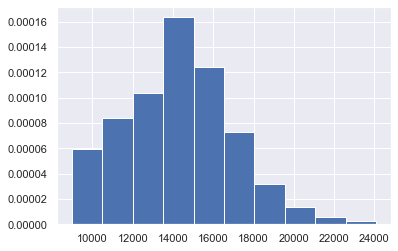

In [93]:
df_temp_2014.demand.hist(density=True) #probability density function

## Feature Engineering

The given dataset contains *year, month, day, weekday, hour, demand* and *temperature*. We are going to add *weekday, season* and *festival* into the dataset. We will consider previous 6 hours' load demand as an input.

In [94]:
df = df_master.copy()

In [95]:
# add weekday info to the dataset
# the initial value for iter_weekday corresponds to the first day of the dataset
iter_weekday = 6
weekday = np.zeros((24*4324,))
for i in range(4324):
    mod = np.mod(iter_weekday, 7)
    for j in range(24):
        if (mod == 6) or (mod == 0):
            weekday[i*24 + j] = 0
        else:
            weekday[i*24 + j] = 1
    iter_weekday += 1

In [96]:
# add season and festival info to the dataset
import datetime
iter_date = datetime.date(2003, 3, 1)
season = np.zeros((24*4324,))
festival = np.zeros((24*4324,))
for i in range(4324):
    month = iter_date.month
    day = iter_date.day
    for j in range(24):
        if (month==4) | (month==5) | ((month==3) and (day>7)) | ((month==6) and (day<8)):
            season[i*24 + j] = 0 #spring
        elif (month==7) | (month==8) | ((month==6) and (day>7)) | ((month==9) and (day<8)):
            season[i*24 + j] = 1 #summer
        elif (month==10) | (month==11) | ((month==9) and (day>7)) | ((month==12) and (day<8)):
            season[i*24 + j] = 2 #autumn
        elif (month==1) | (month==2) | ((month==12) and (day>7)) | ((month==3) and (day<8)):
            season[i*24 + j] = 3 #winter

        if (month == 7) and (day == 4):
            festival[i*24 + j] = 1
        if (month == 11) and (iter_date.weekday() == 4) and (day + 7 > 30):
            festival[i*24 + j] = 1
        if (month == 12) and (day == 25):
            festival[i*24 + j] = 1
    iter_date = iter_date + datetime.timedelta(1)

In [97]:
df_master['weekday'] = weekday

In [98]:
df_master['season'] = season
df_master['season'] = df_master.apply(lambda x:int(x['season']),axis=1) # to keep it integer
df_master['festival'] = festival

In [99]:
#normalising demand with peak value
MAX_DEMAND = max(df_master.demand)

df_master['demand'] = df_master.demand/MAX_DEMAND

In [100]:
df_master['prev_hour_1'] = df_master['demand'].shift(1)
df_master['prev_hour_2'] = df_master['demand'].shift(2)
df_master['prev_hour_3'] = df_master['demand'].shift(3)
df_master['prev_hour_4'] = df_master['demand'].shift(4)
df_master['prev_hour_5'] = df_master['demand'].shift(5)
df_master['prev_hour_6'] = df_master['demand'].shift(6)

## Data Processing
Before fitting data into neural networks model we will do some processing here. In this work demand values are normalized by peak demand value. Season and Month values are one-hot encodded.

List of freatures and their size are shown bellow.
### Features
* M - month = 1 to 12 (one-hot-encoded) - size 12
* W - weekday = 0 or 1 - size 1
* H - hour = 1 to 24  - size 1
* S - Season = 4 (one-hot-encoded) - size 4
* T - temp - size 1
* F - festival = 0 or 1 - size 1
* prev_hour_x - demand at previous $h^{th}$ hour - size 6

Total Feature Size 26

In [101]:
df_onehot = pd.get_dummies(df_master,columns=["month","season"],prefix=["month","season"])

In [102]:
df_onehot.head(2)

,date,year,day,weekday,hour,demand,temperature,festival,prev_hour_1,prev_hour_2,...,month_7,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3
0,2003/3/1,2003,1,0.0,1,0.465680,23,0.0,NaN,NaN,...,0,0,0,0,0,0,0,0,0,1
1,2003/3/1,2003,1,0.0,2,0.448519,22,0.0,0.46568,NaN,...,0,0,0,0,0,0,0,0,0,1


In [103]:
FECOLS = ['month_1', 'month_2', 'month_3', 'month_4', 
          'month_5','month_6', 'month_7', 'month_8',
          'month_9', 'month_10','month_11','month_12',
          "weekday","hour",'prev_hour_1', 'prev_hour_2',
          'prev_hour_3', 'prev_hour_4','prev_hour_5', 'prev_hour_6',
          'season_0', 'season_1','season_2', 'season_3',
          "festival","temperature"]
TGCOL = ["demand"]

In [104]:
df_onehot.fillna(0,inplace=True)

In [105]:
X = df_onehot[FECOLS].values
y = df_onehot[TGCOL].values

In [106]:
print(X.shape,y.shape)

(103776, 26) (103776, 1)


In [107]:
#reshaping to train on LSTM
X = np.reshape(X,(X.shape[0],1,X.shape[1]))
X.shape

(103776, 1, 26)

## Train-Val-Test Split

In [108]:
from sklearn.model_selection import train_test_split

#dataset splitted into train,val,test as 64%,16%,20%
X_train,X_test,Y_train,Y_test = train_test_split( X,y,test_size=0.2, random_state=42)
X_train,X_val,Y_train,Y_val = train_test_split( X_train,Y_train,test_size=0.2, random_state=42)

## Model Loading and Analysis

In this section we will analyze the performance of trained neural network models.

In [109]:
from tensorflow.keras.layers import Dense,LSTM,Dropout, Concatenate
from tensorflow.keras import Sequential,Input, optimizers, losses, models, callbacks

In [110]:
from saveweights import model_functions as models

### LSTM-DENSE Model

Like ANN this model is also consists of 6 hidden layers. However, first 2 layers are replaced by LSTM layers and subsequent 4 layers are Dense layers. Activation function for dense layers is `selu`. 

In [111]:
model1 = models.get_lstm_model((1,26))
model1.summary()

Model: "LSTM_DENSE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1, 26)]           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1, 20)             3760      
_________________________________________________________________
lstm_11 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_22 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_23 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_24 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_25 (Dense)             (None, 20)                4

In [112]:
model1.load_weights('saveweights/model_lstm_dense/'+model1.name)

In [ ]:
scores = model1.evaluate(X_test, Y_test)
print("TEST MAPE :",scores)

### LSTM-DENSE Ensemble

4 different LSTM-Dense model is parallaly trained and concatenated to make the prediction. 4 models are internally different.

First model:
* consist of `selu` activation fucntion for dense layers.  kernel_initializer=`glorot_uniform`,

Second model: 
* consist of `elu` activation fucntion for dense layers.  kernel_initializer=`glorot_uniform`,

Third model: 
* consist of `gelu` activation fucntion for dense layers.  kernel_initializer=`random_normal`,

Forth model: 
* consist of `softplus` activation fucntion for dense layers.  kernel_initializer=`random_normal`,

Finally, the last layers of these models are concatenated and pass it to the final layer to make predictions. The main idea is that these 4 models will learn input features differently so that the model as a whole can gain better generalization capability.


In [114]:
model2 = models.get_lstm_model_ensemble((1,26))
# model2.summary()

In [115]:
model2.load_weights('saveweights/model_lstm_dense_ensemble/'+model2.name)

### Performance Summary 

We have performed a range of experiments for this task with changing layers, activation functions, hyperparameters tuning, etc. The finnal models output are summarized bellow. 


LSTM-DENSE

* 300 Epochs | Best at 286 loss: 0.7590 - val_loss: 0.6342 | TEST MAPE : 0.6130

LSTM-DENSE-ENSEMBLE 
* 300 Epochs | Best at 295 loss: 0.7452 - val_loss: 0.5885 | TEST MAPE : 0.5723



In [116]:
import json

In [117]:
#loading training history of the models 



f = open('saveweights/model_lstm_dense/history.json')
lstm_dense_history = json.load(f)

f = open('saveweights/model_lstm_dense_ensemble//history.json')
lstm_dense_ensemble_history = json.load(f)


In [118]:
lstm_loss = lstm_dense_history['loss']
lstm_val_loss = lstm_dense_history['val_loss']

lstm_ensemble_loss=  lstm_dense_ensemble_history['loss']
lstm_ensemble_val_loss=  lstm_dense_ensemble_history['val_loss']

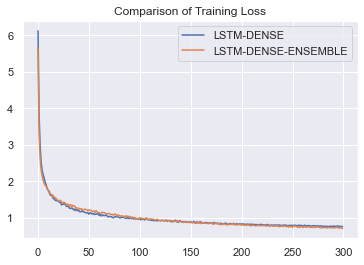

In [119]:
plt.figure()
plt.title('Comparison of Training Loss')
plt.plot(lstm_loss)
plt.plot(lstm_ensemble_loss)
plt.legend(['LSTM-DENSE','LSTM-DENSE-ENSEMBLE'])

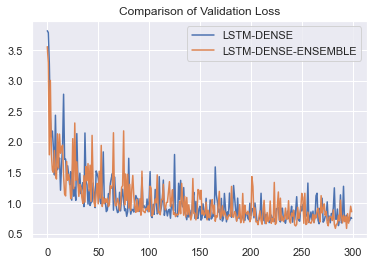

In [120]:
plt.figure()
plt.title('Comparison of Validation Loss')
plt.plot(lstm_val_loss)
plt.plot(lstm_ensemble_val_loss)
plt.legend(['LSTM-DENSE','LSTM-DENSE-ENSEMBLE'])

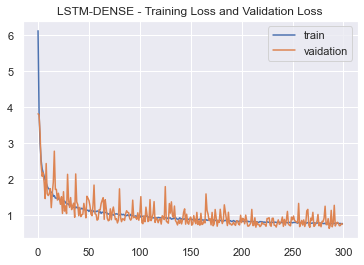

In [121]:
plt.figure()
plt.title('LSTM-DENSE - Training Loss and Validation Loss')
plt.plot(lstm_loss)
plt.plot(lstm_val_loss)
plt.legend(['train','vaidation'])

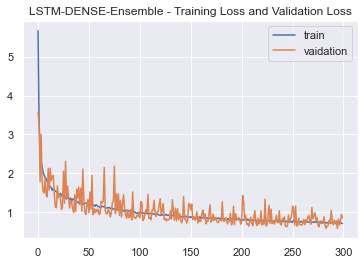

In [122]:
plt.figure()
plt.title('LSTM-DENSE-Ensemble - Training Loss and Validation Loss')
plt.plot(lstm_ensemble_loss)
plt.plot(lstm_ensemble_val_loss)
plt.legend(['train','vaidation'])

## Visualization


In [123]:
def visualize_day(df_onehot,date,model=None,dense_only=False):
    #extracting data for the given date
    temp = df_onehot[df_onehot.date==date]
    temp_x = temp[FECOLS].values #input features
    temp_y = temp[TGCOL].values * MAX_DEMAND #true demands
    temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))

    #prediction
    preds = model.predict(temp_x)
    if dense_only:
        preds = np.reshape(preds,(24,1))

    y_preds = preds * MAX_DEMAND #predicted demands
    plt.figure()
    plt.plot(temp_y)
    plt.plot(y_preds)
    plt.legend(["actual","predicted"])
    plt.title(date)

## LSTM-DENSE

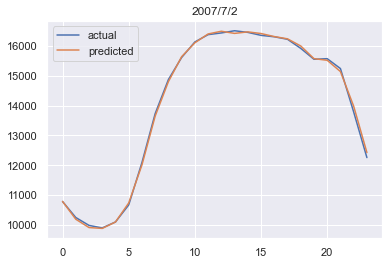

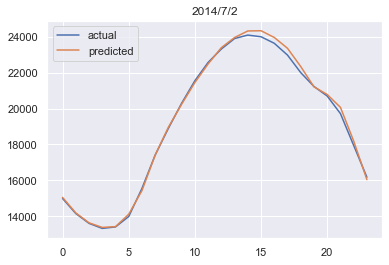

In [124]:
visualize_day(df_onehot,date='2007/7/2',model=model1)
visualize_day(df_onehot,date='2014/7/2',model=model1)

## LSTM-DENSE Ensemble

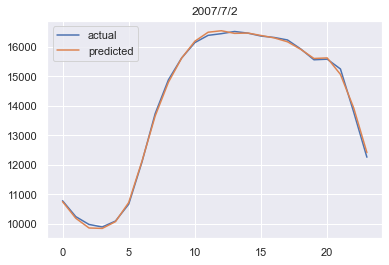

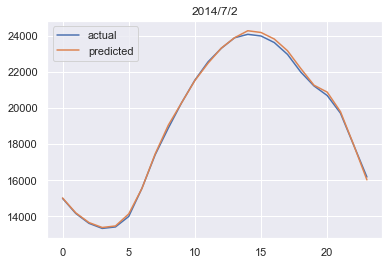

In [125]:
visualize_day(df_onehot,date='2007/7/2',model=model2)
visualize_day(df_onehot,date='2014/7/2',model=model2)

## Visualization for 1 week

In [126]:
#extracting 1 week data for the given year and month
temp = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]
temp = temp[0:168]

temp_x = temp[FECOLS].values #input features
temp_y = temp[TGCOL].values * MAX_DEMAND #true demands
temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))


<ipython-input-126-c33c1a1d9667>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]


## LSTM-DENSE

In [127]:
#prediction
preds = model1.predict(temp_x)
y_preds = abs(preds) * MAX_DEMAND #predicted demands

Text(0.5, 1.0, '2014 January')

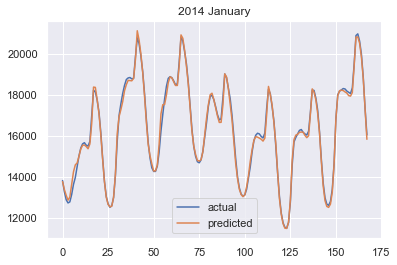

In [128]:
plt.figure()
plt.plot(temp_y)
plt.plot(y_preds)
plt.legend(["actual","predicted"])
plt.title('2014 January')

## LSTM-DENSE Ensemble

In [129]:
#prediction
preds = model2.predict(temp_x)
y_preds = abs(preds) * MAX_DEMAND #predicted demands

Text(0.5, 1.0, '2014 January')

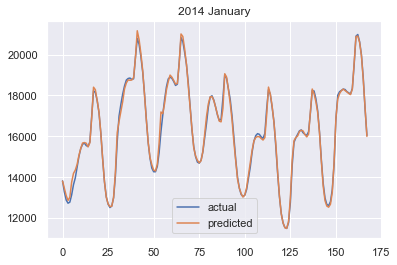

In [130]:
plt.figure()
plt.plot(temp_y)
plt.plot(y_preds)
plt.legend(["actual","predicted"])
plt.title('2014 January')

## Performance Analysis

Here we will visualise 95$\%$ confidence interval for the best model (LSTM-DENSE-ENSEMBLE).

In [175]:
temp_2014_january = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]

<ipython-input-175-469edaa302a0>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  temp_2014_january = df_onehot[df_onehot.year==2014][df_onehot.month_1==1]


In [176]:
temp_x = temp_2014_january[FECOLS].values #input features
temp_y = temp_2014_january[TGCOL].values * MAX_DEMAND #true demands
temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))

### LSTM-DENSE

In [177]:
preds = model1.predict(temp_x)

In [178]:
temp_2014_january['predicted_model1'] = preds

In [179]:
temp_2014_january

,date,year,day,weekday,hour,demand,temperature,festival,prev_hour_1,prev_hour_2,...,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3,predicted_model1
95016,2014/1/1,2014,1,1.0,1,0.500362,20,0.0,0.528745,0.555897,...,0,0,0,0,0,0,0,0,1,0.498504
95017,2014/1/1,2014,1,1.0,2,0.480776,19,0.0,0.500362,0.528745,...,0,0,0,0,0,0,0,0,1,0.484531
95018,2014/1/1,2014,1,1.0,3,0.466476,17,0.0,0.480776,0.500362,...,0,0,0,0,0,0,0,0,1,0.474238
95019,2014/1/1,2014,1,1.0,4,0.460828,17,0.0,0.466476,0.480776,...,0,0,0,0,0,0,0,0,1,0.465797
95020,2014/1/1,2014,1,1.0,5,0.462638,17,0.0,0.460828,0.466476,...,0,0,0,0,0,0,0,0,1,0.471066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95755,2014/1/31,2014,31,1.0,20,0.619542,36,0.0,0.637137,0.637390,...,0,0,0,0,0,0,0,0,1,0.620947
95756,2014/1/31,2014,31,1.0,21,0.598436,35,0.0,0.619542,0.637137,...,0,0,0,0,0,0,0,0,1,0.592889
95757,2014/1/31,2014,31,1.0,22,0.567917,34,0.0,0.598436,0.619542,...,0,0,0,0,0,0,0,0,1,0.559119
95758,2014/1/31,2014,31,1.0,23,0.526790,34,0.0,0.567917,0.598436,...,0,0,0,0,0,0,0,0,1,0.517935


Text(0.5, 1.0, 'Actual load and 95% prediction intervals for January 2014')

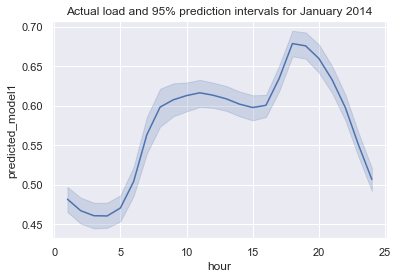

In [180]:
sns.lineplot(x='hour',y='predicted_model1',data=temp_2014_january,ci=95)
plt.title('Actual load and 95% prediction intervals for January 2014')

### LSTM-DENSE-ENSEMBLE

In [181]:
preds = model2.predict(temp_x)

In [182]:
temp_2014_january['predicted_model2'] = preds

In [183]:
temp_2014_january

,date,year,day,weekday,hour,demand,temperature,festival,prev_hour_1,prev_hour_2,...,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3,predicted_model1,predicted_model2
95016,2014/1/1,2014,1,1.0,1,0.500362,20,0.0,0.528745,0.555897,...,0,0,0,0,0,0,0,1,0.498504,0.499941
95017,2014/1/1,2014,1,1.0,2,0.480776,19,0.0,0.500362,0.528745,...,0,0,0,0,0,0,0,1,0.484531,0.487393
95018,2014/1/1,2014,1,1.0,3,0.466476,17,0.0,0.480776,0.500362,...,0,0,0,0,0,0,0,1,0.474238,0.474321
95019,2014/1/1,2014,1,1.0,4,0.460828,17,0.0,0.466476,0.480776,...,0,0,0,0,0,0,0,1,0.465797,0.465790
95020,2014/1/1,2014,1,1.0,5,0.462638,17,0.0,0.460828,0.466476,...,0,0,0,0,0,0,0,1,0.471066,0.471313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95755,2014/1/31,2014,31,1.0,20,0.619542,36,0.0,0.637137,0.637390,...,0,0,0,0,0,0,0,1,0.620947,0.618528
95756,2014/1/31,2014,31,1.0,21,0.598436,35,0.0,0.619542,0.637137,...,0,0,0,0,0,0,0,1,0.592889,0.595236
95757,2014/1/31,2014,31,1.0,22,0.567917,34,0.0,0.598436,0.619542,...,0,0,0,0,0,0,0,1,0.559119,0.561252
95758,2014/1/31,2014,31,1.0,23,0.526790,34,0.0,0.567917,0.598436,...,0,0,0,0,0,0,0,1,0.517935,0.518308


Text(0.5, 1.0, 'Actual load and 95% prediction intervals for January 2014')

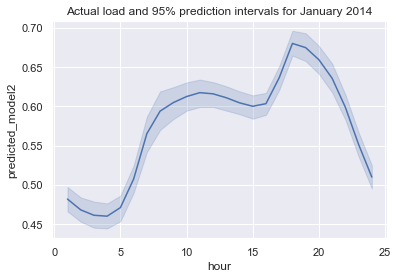

In [184]:
sns.lineplot(x='hour',y='predicted_model2',data=temp_2014_january,ci=95)
plt.title('Actual load and 95% prediction intervals for January 2014')

## Extrapolate for Different Duration 

#### Extrapolation Analysis for 2014

In [143]:
temp = df_onehot[df_onehot.year==2014]
temp.reset_index(drop=True,inplace=True)
temp[['hour','prev_hour_1', 'prev_hour_2',
          'prev_hour_3', 'prev_hour_4','prev_hour_5', 'prev_hour_6']].head()

,hour,prev_hour_1,prev_hour_2,prev_hour_3,prev_hour_4,prev_hour_5,prev_hour_6
0,1,0.528745,0.555897,0.585475,0.613207,0.641192,0.671132
1,2,0.500362,0.528745,0.555897,0.585475,0.613207,0.641192
2,3,0.480776,0.500362,0.528745,0.555897,0.585475,0.613207
3,4,0.466476,0.480776,0.500362,0.528745,0.555897,0.585475
4,5,0.460828,0.466476,0.480776,0.500362,0.528745,0.555897


In [138]:
temp_x = temp[FECOLS].values
temp_y = temp[TGCOL].values

In [139]:
temp_x = np.reshape(temp_x,(temp_x.shape[0],1,temp_x.shape[1]))

In [140]:
df_extrapolate = temp.copy()
start_prev_1 = df_extrapolate.iloc[0].prev_hour_1
start_prev_2 = df_extrapolate.iloc[0].prev_hour_2
start_prev_3 = df_extrapolate.iloc[0].prev_hour_3
start_prev_4 = df_extrapolate.iloc[0].prev_hour_4
start_prev_5 = df_extrapolate.iloc[0].prev_hour_5
start_prev_6 = df_extrapolate.iloc[0].prev_hour_6

In [141]:
df_extrapolate['prev_hour_1'] = 0
df_extrapolate['prev_hour_2'] = 0
df_extrapolate['prev_hour_3'] = 0
df_extrapolate['prev_hour_4'] = 0
df_extrapolate['prev_hour_5'] = 0
df_extrapolate['prev_hour_6'] = 0
df_extrapolate['predicted'] = 0

df_extrapolate.loc[0,'prev_hour_1'] = start_prev_1
df_extrapolate.loc[0,'prev_hour_2'] = start_prev_2
df_extrapolate.loc[0,'prev_hour_3'] = start_prev_3
df_extrapolate.loc[0,'prev_hour_4'] = start_prev_4
df_extrapolate.loc[0,'prev_hour_5'] = start_prev_5
df_extrapolate.loc[0,'prev_hour_6'] = start_prev_6

df_master['prev_hour_1'] = df_master['demand'].shift(1)
df_master['prev_hour_2'] = df_master['demand'].shift(2)
df_master['prev_hour_3'] = df_master['demand'].shift(3)
df_master['prev_hour_4'] = df_master['demand'].shift(4)
df_master['prev_hour_5'] = df_master['demand'].shift(5)
df_master['prev_hour_6'] = df_master['demand'].shift(6)

In [144]:
df_extrapolate.head()

,date,year,day,weekday,hour,demand,temperature,festival,prev_hour_1,prev_hour_2,...,month_8,month_9,month_10,month_11,month_12,season_0,season_1,season_2,season_3,predicted
0,2014/1/1,2014,1,1.0,1,0.500362,20,0.0,0.528745,0.555897,...,0,0,0,0,0,0,0,0,1,0
1,2014/1/1,2014,1,1.0,2,0.480776,19,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
2,2014/1/1,2014,1,1.0,3,0.466476,17,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
3,2014/1/1,2014,1,1.0,4,0.460828,17,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,2014/1/1,2014,1,1.0,5,0.462638,17,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0


In [145]:
from tqdm import tqdm

In [146]:
for index in tqdm(range(df_extrapolate.shape[0])):
    sample = df_extrapolate[index:index+1]
    X = sample[FECOLS].values
    X = np.reshape(X,(X.shape[0],1,X.shape[1]))
    
    pred = model2.predict(X)
    
    #storing values in dataframe
    df_extrapolate.loc[index,'predicted'] = pred.tolist()[0][0]
    df_extrapolate.loc[index+1,'prev_hour_1'] = pred.tolist()[0][0]
    df_extrapolate.loc[index+1,'prev_hour_2'] = df_extrapolate.loc[index,'prev_hour_1']
    df_extrapolate.loc[index+1,'prev_hour_3'] = df_extrapolate.loc[index,'prev_hour_2']
    df_extrapolate.loc[index+1,'prev_hour_4'] = df_extrapolate.loc[index,'prev_hour_3']
    df_extrapolate.loc[index+1,'prev_hour_5'] = df_extrapolate.loc[index,'prev_hour_4']
    df_extrapolate.loc[index+1,'prev_hour_6'] = df_extrapolate.loc[index,'prev_hour_5']
    

100%|██████████| 8760/8760 [11:33<00:00, 12.63it/s]


In [148]:
df_extrapolate[['hour','prev_hour_1', 'prev_hour_2',
          'prev_hour_3', 'prev_hour_4','prev_hour_5', 'prev_hour_6']].head()

,hour,prev_hour_1,prev_hour_2,prev_hour_3,prev_hour_4,prev_hour_5,prev_hour_6
0,1.0,0.528745,0.555897,0.585475,0.613207,0.641192,0.671132
1,2.0,0.499941,0.528745,0.555897,0.585475,0.613207,0.641192
2,3.0,0.486926,0.499941,0.528745,0.555897,0.585475,0.613207
3,4.0,0.480748,0.486926,0.499941,0.528745,0.555897,0.585475
4,5.0,0.481034,0.480748,0.486926,0.499941,0.528745,0.555897


In [149]:
gc.collect()

182593

In [150]:
from tensorflow.keras.losses import MeanAbsolutePercentageError as mape

In [151]:
loss_object = mape()

### A Day Ahead

In [171]:
day = df_extrapolate[0:24]

y_true = day['demand'].dropna()
y_pred = day['predicted'].dropna()

In [172]:
loss = loss_object(y_true,y_pred)
loss.numpy()

10.87806224822998

### A Week Ahead

In [152]:
week = df_extrapolate[0:7*24]

In [153]:
y_true = week['demand'].dropna()
y_pred = week['predicted'].dropna()

In [154]:
loss = loss_object(y_true,y_pred)
loss.numpy()

4.041378974914551

### A Month Ahead

In [155]:
month = df_extrapolate[0:30*24]

In [156]:
y_true = month['demand'].dropna()
y_pred = month['predicted'].dropna()

In [157]:
loss = loss_object(y_true,y_pred)
loss.numpy()

2.387392044067383

### A Year Ahead

In [158]:
y_true = df_extrapolate['demand'].dropna()
y_pred = df_extrapolate['predicted'].dropna()

In [159]:
loss = loss_object(y_true,y_pred)
loss.numpy()

4.248743057250977

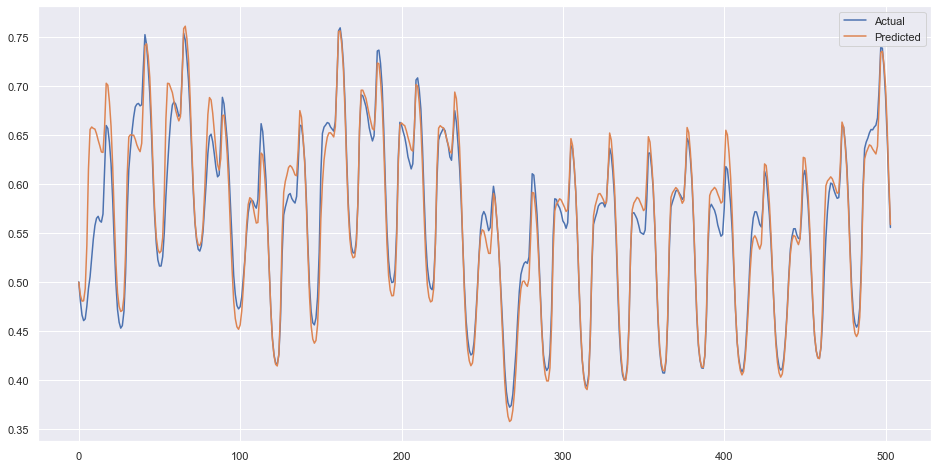

In [160]:
plt.figure(figsize=(16,8))
plt.plot(y_true[0:504])
plt.plot(y_pred[0:504])
plt.legend(['Actual','Predicted'])

In [161]:
losses = []
for i in range(1,13):
    m_str = "month_"+str(i)
    y_true = df_extrapolate[df_extrapolate[m_str]==1]['demand'].dropna()
    y_pred = df_extrapolate[df_extrapolate[m_str]==1]['predicted'].dropna()
    loss = loss_object(y_true,y_pred)
    losses.append(loss.numpy())

In [162]:
losses

[2.4307665824890137,
 2.3159027099609375,
 2.18302321434021,
 4.777632236480713,
 6.7867045402526855,
 7.634559154510498,
 4.258455753326416,
 7.267923831939697,
 2.7195918560028076,
 4.5868048667907715,
 3.3199245929718018,
 2.563570976257324]

Text(0, 0.5, 'MAPE')

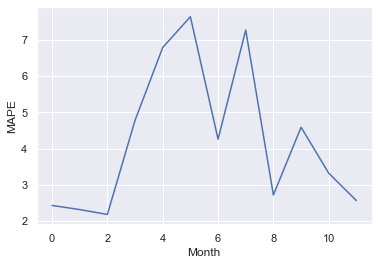

In [163]:
plt.plot(losses)
plt.xlabel('Month')
plt.ylabel('MAPE')


In [72]:
# best = 100
# for i,loss in enumerate(lstm_loss,1):
#     if best>lstm_val_loss[i]:
#         best =lstm_val_loss[i]
#         best_at = i
#     print('Epoch:',i)
#     print(f'Best at {best_at} loss: {lstm_loss[i]} - val_loss: {lstm_val_loss[i]}\n',)
    